# Using DQN and Double DQN in Pearl with different neural network instantiations.

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/sequential_decision_making/DQN_and_DoubleDQN_example.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

- The purpose of this tutorial is twofold. First, it illustrates how users can use implementations of value based methods, for example, DQN and Double DQN, in Pearl. We use a simple Gym environment for illustration.

- Second, it illustrates how users can instantiate a neural network (outside of a Pearl Agent) and pass it to different policy learners in Pearl. For both examples (DQN and Double DQN), we use an instantiation of `QValueNetworks` outside of the Pearl Agent. The default way right now is to instantiate a Q-value network inside the agent's policy learner.

- Users can also instantiate custom networks and use these with different policy learners in Pearl, but are expected to follow the general design of the value networks/critic networks/actor networks base class. For example, for value based methods such as DQN and Double DQN, users should follow the design of the `QValueNetwork` base class.

In [1]:
%load_ext autoreload
%autoreload 2

# Pearl Installation

If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.



In [2]:
# Pearl installation from github. This install also includes PyTorch, Gym and Matplotlib

%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

Cloning into 'Pearl'...
remote: Enumerating objects: 6139, done.
remote: Counting objects: 100% (2346/2346), done.
remote: Compressing objects: 100% (763/763), done.
remote: Total 6139 (delta 1785), reused 2048 (delta 1565), pack-reused 3793 (from 1)
Receiving objects: 100% (6139/6139), 54.48 MiB | 6.89 MiB/s, done.
Resolving deltas: 100% (4115/4115), done.
/content/Pearl
Processing /content/Pearl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [3]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.3 MB/s eta 0:00:00


In [4]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376101 sha256=cfbd7a222a1f38e15f3536ddc8a2e71633270cd106c1571419cbaa4f9b71dc89
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


# Import Modules

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from pearl.neural_networks.sequential_decision_making.actor_networks import VanillaContinuousActorNetwork
from pearl.policy_learners.sequential_decision_making.ppo import ProximalPolicyOptimization
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.policy_learners.exploration_modules.common.epsilon_greedy_exploration import EGreedyExploration
from pearl.replay_buffers.sequential_decision_making.fifo_on_policy_replay_buffer import FIFOOnPolicyReplayBuffer
from pearl.replay_buffers.sequential_decision_making.on_policy_replay_buffer import OnPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.utils.instantiations.spaces.discrete import DiscreteSpace
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)

set_seed(0)

# Instantiate a simple Q value network

- In Pearl, Q-value networks assume inputs in the form of (state representation, action representation) and output estimated Q(s,a) through the `get_q_values` function.


In [ ]:
env = GymEnvironment("CartPole-v1", render_mode="rgb_array")
num_actions = env.action_space.n

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                    # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Example 1: Set up a simple DQN agent

In [ ]:
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DQNagent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network, # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# Online interaction and learning

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


episode 20, step 192, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 10.0
episode 40, step 663, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 156.0
episode 60, step 2372, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 68.0
episode 80, step 6459, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 183.0
episode 100, step 15053, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 246.0
episode 120, step 24252, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 500.0
episode 140, step 33758, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 468.0
episode 160, step 41787, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 244.0
episode 180, step 47531, agent=PearlAgent with DeepQLearning

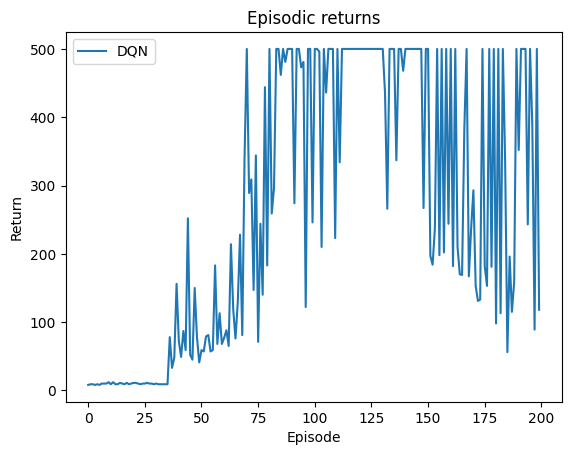

In [ ]:
# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns

info = online_learning(
    agent=DQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info["return"], "DQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info["return"])), info["return"], label="DQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# Example 2: Set up a simple Double DQN agent

In [ ]:
# Set up a different instance of a Q value network.

# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_network_DoubleDQN = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                        # dimension of the action representation
                                       hidden_dims=hidden_dims,                       # dimensions of the intermediate layers
                                       output_dim=1)                                  # set to 1 (Q values are scalars)


In [ ]:
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DoubleDQN` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_network_DoubleDQN,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# Online interaction and learning

episode 20, step 208, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 8.0
episode 40, step 828, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 44.0
episode 60, step 1634, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 42.0
episode 80, step 4946, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 143.0
episode 100, step 9835, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 173.0
episode 120, step 15509, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 209.0
episode 140, step 21811, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 216.0
episode 160, step 30454, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 500.0
episode 180, step 39663, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPo

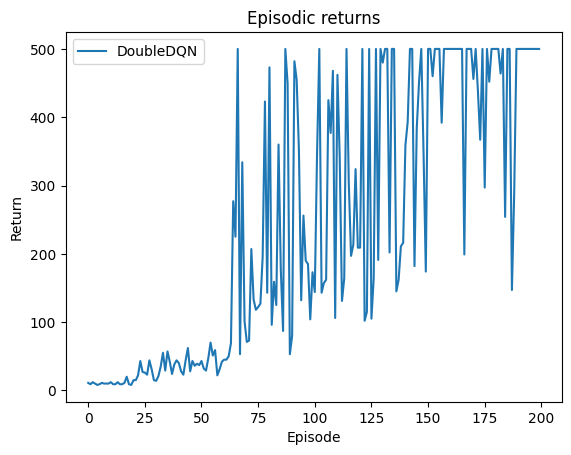

In [ ]:
# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_DoubleDQN["return"])), info_DoubleDQN["return"], label="DoubleDQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [5]:
env = GymEnvironment("LunarLander-v2")
num_actions = env.action_space.n

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_network_DoubleDQN = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                        # dimension of the action representation
                                       hidden_dims=hidden_dims,                       # dimensions of the intermediate layers
                                       output_dim=1)                                  # set to 1 (Q values are scalars)


# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        exploration_module=EGreedyExploration(0.10), #Add more exploriation to network
        network_instance=Q_network_DoubleDQN,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(1_000_000),
)

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=5000,
    print_every_x_episodes=50,   # print returns after every 50 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_DoubleDQN["return"])), info_DoubleDQN["return"], label="DoubleDQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()
env.close()

episode 50, step 8828, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -137.74990234785946
episode 100, step 38069, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -170.42641136841848
episode 150, step 62622, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -161.12291872827336
episode 200, step 90505, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -81.53516342618968
episode 250, step 133566, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -19.25356514909072
episode 300, step 174917, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -177.7764789875655
episode 350, step 213289, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -81.11816950255889
episode 400, step 251600, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayB

KeyboardInterrupt: 

In [ ]:
env = GymEnvironment("LunarLander-v2")
print(f"Number of Actions: {env.action_space.n}")
print(f"Is the Environment Action Space Continuous: {env.action_space.is_continuous}")
print(f"Number of Observations: {env.observation_space.shape[0]}")
num_actions = env.action_space.n

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]

# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env.action_space.n,
)

assert isinstance(env.action_space, DiscreteSpace)
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        actor_hidden_dims=hidden_dims,
        critic_hidden_dims=hidden_dims,
        use_critic=True,
        action_representation_module=action_representation_module,
    ),
    replay_buffer=OnPolicyReplayBuffer(1_000_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=5000,
    print_every_x_episodes=50,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_PPO["return"], "PPO-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_PPO["return"])), info_PPO["return"], label="PPO")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()
env.close()

Number of Actions: 4
Is the Environment Action Space Continuous: False
Number of Observations: 8


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


episode 50, step 4233, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -116.1437092423439
episode 100, step 8629, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -287.29033829830587


In [ ]:
env = GymEnvironment("LunarLanderContinuous-v2")
print(env.action_space.action_dim)
print(env.action_space.is_continuous)
print(env.observation_space.shape[0])
num_actions = env.action_space

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]

# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env.action_space,
)

PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        actor_hidden_dims=hidden_dims,
        critic_hidden_dims=hidden_dims,
        use_critic=True,
        batch_size=64,
        training_rounds=10,
        action_representation_module=action_representation_module,
    ),
    replay_buffer=OnPolicyReplayBuffer(1_000_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=5000,
    print_every_x_episodes=50,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_PPO["return"], "PPO-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_PPO["return"])), info_PPO["return"], label="PPO")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()